In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Setup

In [2]:
mer = pd.ExcelFile('dataset/2. MER PointTransaction 2023_RetailsResellers_Final.xlsx')
mer_sheet1 = pd.read_excel(mer, 'MER Transaction')
mer_sheet2 = pd.read_excel(mer, 'Point Per Litre')

In [3]:
print(mer_sheet1.shape)
mer_sheet1.head()

(9429, 8)


,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L)
0,2023-02-14,A,ERW_AI8N2021070006,Retails,Pathum Thani,123150,"MOBIL MULTIPURPOSE ATF, 208LT DR",7168
1,2023-04-20,D,ERW_DBG72020110082,Reseller,Songkhla,124213,MOBIL ATF 220 D 208LT,912
2,2023-10-19,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7340
3,2023-07-25,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,1640
4,2023-10-12,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7080


In [4]:
print(mer_sheet2.shape)
mer_sheet2.head()

(145, 2)


,MatNo,Points
0,144673,10
1,140521,10
2,144473,10
3,145832,10
4,140418,10


In [5]:
mer = pd.merge(mer_sheet1, mer_sheet2, on='MatNo', how='left')
print(mer.shape)
mer.head()

(9429, 9)


,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points
0,2023-02-14,A,ERW_AI8N2021070006,Retails,Pathum Thani,123150,"MOBIL MULTIPURPOSE ATF, 208LT DR",7168,1
1,2023-04-20,D,ERW_DBG72020110082,Reseller,Songkhla,124213,MOBIL ATF 220 D 208LT,912,1
2,2023-10-19,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7340,1
3,2023-07-25,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,1640,1
4,2023-10-12,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7080,1


Handle null/ missing values

In [7]:
mer.isnull().sum()

Invoicedate      0
Distributor      0
GroupId          0
Type             0
Provincename     0
MatNo            0
Material Name    0
New_Volume(L)    0
Points           0
dtype: int64

In [8]:
# Fix Typos
mat_default = mer_sheet1.sort_values(['MatNo', 'Material Name']).groupby('MatNo').head(1)\
                        .loc[:, ['MatNo', 'Material Name']].set_index('MatNo')
mat_default['Material Name'] = mat_default['Material Name'].str.replace('โมบิล', 'MOBIL')
mat_default['Material Name'] = mat_default['Material Name'].str.replace('เดลแวค', 'DELVAC')
mat_default['Material Name'] = mat_default['Material Name'].str.replace('สเปเชียล', 'SPECIAL')
mat_default.loc[ mat_default.index == 140563, 'Material Name'] = 'MOBIL DELVAC 1 GEAR OIL 75W90, 1/35LB'

mat_default.shape
# with pd.option_context('display.max_rows', None):
#     display(mat_default)

(145, 1)

In [9]:
for i in mer['MatNo'].unique():
    mer.loc[mer['MatNo'] == i, 'Material Name'] = mat_default.loc[i, 'Material Name']
            
mer[ ['MatNo', 'Material Name']].drop_duplicates().shape

(145, 2)

In [10]:
mer.dropna(inplace=True)
mer.isnull().any()

Invoicedate      False
Distributor      False
GroupId          False
Type             False
Provincename     False
MatNo            False
Material Name    False
New_Volume(L)    False
Points           False
dtype: bool

### EDA
Points per group

In [11]:
mer['Provincename'] = mer['Provincename'].replace('N\A', np.nan)
mer[mer['Provincename'].isnull()].head()

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points
1705,2023-11-03,A,ERW_A7QF2022060002,Retails,NaN,140043,"MOBIL ATF 3309 , 12x1 LT CTN",5392,1
1845,2023-02-13,A,ERW_A7QF2022060003,Retails,NaN,140418,MOBIL 1 TBD 5W-40 4X6L/CAR,5088,10
1910,2023-02-13,A,ERW_A7QF2022060003,Retails,NaN,140521,"MOBIL 1 0W-40 (SN), 4x4LT CTN",608,10
2260,2023-02-13,A,ERW_A7QF2022060003,Retails,NaN,142923,MOBIL SPECIAL 20W-50 4X4L/CAR,6544,1
2275,2023-10-26,A,ERW_A7QF2022060003,Retails,NaN,142923,MOBIL SPECIAL 20W-50 4X4L/CAR,1104,1


**Churn Detection**\
hypothesis: if trending of volume tend to decrease over year, we will classify as 'Churn'

In [12]:
mer['quarter'] = mer['Invoicedate'].dt.quarter
volume_by_quarter = mer.groupby(['GroupId', 'MatNo', 'quarter'])\
                        .agg({'New_Volume(L)': 'sum'})
volume_by_quarter = volume_by_quarter.sort_values(by=['GroupId', 'MatNo', 'quarter']).reset_index()
volume_by_quarter.head(5)

,GroupId,MatNo,quarter,New_Volume(L)
0,ERW_A1DS2023040002,143874,3,2328
1,ERW_A1DS2023040002,143874,4,5532
2,ERW_A1DS2023040002,143877,2,12544
3,ERW_A1DS2023040002,143877,3,8120
4,ERW_A1DS2023040002,143877,4,5040


In [13]:
churn_df = pd.pivot_table(data=volume_by_quarter, values='New_Volume(L)', 
               index=['GroupId', 'MatNo'], columns='quarter').reset_index()
churn_df = churn_df.fillna(0)
churn_df['volume_diff'] = 0

# iterate over quarter for calculating volume trending
for ind in churn_df.index:
    result = 0
    for quarter in [4, 3, 2]:
        for i in reversed(range(1, quarter)):
            temp1 = churn_df.loc[ind, quarter]  # quarter หลัง 
            temp2 = churn_df.loc[ind, i]  # quarter ก่อน
            if temp1 != 0 and temp2 != 0:
                result += temp1 - temp2
                break
            else:
                continue
        
        churn_df.loc[ind, 'volume_diff'] = result
        
# Churn classification
churn_df['Churn'] = ' '        
# Check quarter order
for ind in churn_df[churn_df['volume_diff'] == 0].index:
    q_check = []
    for quarter in [1, 2, 3, 4]:
        if churn_df.loc[ind, quarter] != 0:
            q_check.append(quarter)
        else:
            continue
        
    if q_check.count(4) != 0:  # have order in quarter 4
        churn_df.loc[ind, 'Churn'] = 'No'
    else:  
        # ซื้อ 2 quarter ขึ้นไป
        if len(q_check) >= 2:
            churn_df.loc[ind, 'Churn'] = 'No'
        else:
            churn_df.loc[ind, 'Churn'] = 'Yes'

# check by sales consecutive different
for ind in churn_df[ churn_df['volume_diff'] != 0 ].index:
    if churn_df.loc[ind, 'volume_diff'] < 0:
        churn_df.loc[ind, 'Churn'] = 'Yes'
    else:
        churn_df.loc[ind, 'Churn'] = 'No'

churn_df

quarter,GroupId,MatNo,1,2,3,4,volume_diff,Churn
0,ERW_A1DS2023040002,143874,0.0,0.0,2328.0,5532.0,3204,No
1,ERW_A1DS2023040002,143877,0.0,12544.0,8120.0,5040.0,-7504,Yes
2,ERW_A1DS2023040002,145826,0.0,7160.0,0.0,4580.0,-2580,Yes
3,ERW_A1DS2023040003,145472,6076.0,0.0,0.0,0.0,0,Yes
4,ERW_A1DS2023040003,145474,0.0,1344.0,0.0,0.0,0,Yes
...,...,...,...,...,...,...,...,...
4629,ERW_DYZP2023100001,143877,0.0,0.0,1148.0,308.0,-840,Yes
4630,ERW_DYZP2023100001,145472,0.0,0.0,0.0,9800.0,0,No
4631,ERW_DYZP2023100001,145474,0.0,0.0,11844.0,3640.0,-8204,Yes
4632,ERW_DYZP2023100001,145497,0.0,0.0,16604.0,5992.0,-10612,Yes


In [14]:
final_churn = pd.merge(mer, churn_df[ ['GroupId', 'MatNo', 'Churn']], on=['GroupId', 'MatNo'], how='left')
print(final_churn['Churn'].isnull().any())
final_churn.rename(columns={'Provincename': 'Province'}, inplace=True)
final_churn.head()

False


,Invoicedate,Distributor,GroupId,Type,Province,MatNo,Material Name,New_Volume(L),Points,quarter,Churn
0,2023-02-14,A,ERW_AI8N2021070006,Retails,Pathum Thani,123150,"MOBIL MULTIPURPOSE ATF, 208LT DR",7168,1,1,Yes
1,2023-04-20,D,ERW_DBG72020110082,Reseller,Songkhla,124213,MOBIL ATF 220 D 208LT,912,1,2,Yes
2,2023-10-19,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7340,1,4,No
3,2023-07-25,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,1640,1,3,No
4,2023-10-12,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7080,1,4,No


In [15]:
mer.to_csv('clean_data/MER_clean.csv', index=False)

Add region features

In [16]:
province_region_english = {
    "Bangkok": "Central",
    "Samut Prakan": "Central",
    "Nonthaburi": "Central",
    "Pathum Thani": "Central",
    "Phra Nakhon Si Ayutthaya": "Central",
    "Ang Thong": "Central",
    "Lop Buri": "Central",
    "Sing Buri": "Central",
    "Chainat": "Central",
    "Saraburi": "Central",
    "Chon Buri": "Eastern",
    "Rayong": "Eastern",
    "Chanthaburi": "Eastern",
    "Trat": "Eastern",
    "Chachoengsao": "Eastern",
    "Prachin Buri": "Eastern",
    "Nakhon Nayok": "Eastern",
    "Sa Kaeo": "Eastern",
    "Nakhon Ratchasima": "Northeastern",
    "Buri Ram": "Northeastern",
    "Surin": "Northeastern",
    "Si Sa Ket": "Northeastern",
    "Ubon Ratchathani": "Northeastern",
    "Yasothon": "Northeastern",
    "Chaiyaphum": "Northeastern",
    "Amnat Charoen": "Northeastern",
    "Nong Bua Lam Phu": "Northeastern",
    "Khon Kaen": "Northeastern",
    "Udon Thani": "Northeastern",
    "Loei": "Northeastern",
    "Nong Khai": "Northeastern",
    "Maha Sarakham": "Northeastern",
    "Roi Et": "Northeastern",
    "Kalasin": "Northeastern",
    "Sakon Nakhon": "Northeastern",
    "Nakhon Phanom": "Northeastern",
    "Mukdahan": "Northeastern",
    "Chiang Mai": "Northern",
    "Lamphun": "Northern",
    "Lampang": "Northern",
    "Uttaradit": "Northern",
    "Phrae": "Northern",
    "Nan": "Northern",
    "Phayao": "Northern",
    "Chiang Rai": "Northern",
    "Mae Hong Son": "Northern",
    "Nakhon Sawan": "Central",
    "Uthai Thani": "Central",
    "Kamphaeng Phet": "Central",
    "Tak": "Western",
    "Sukhothai": "Central",
    "Phitsanulok": "Central",
    "Phichit": "Central",
    "Phetchabun": "Central",
    "Ratchaburi": "Western",
    "Kanchanaburi": "Western",
    "Suphan Buri": "Central",
    "Nakhon Pathom": "Central",
    "Samut Sakhon": "Central",
    "Samut Songkhram": "Central",
    "Phetchaburi": "Western",
    "Prachuap Khiri Khan": "Western",
    "Nakhon Si Thammarat": "Southern",
    "Krabi": "Southern",
    "Phangnga": "Southern",
    "Phuket": "Southern",
    "Surat Thani": "Southern",
    "Ranong": "Southern",
    "Chumphon": "Southern",
    "Songkhla": "Southern",
    "Satun": "Southern",
    "Trang": "Southern",
    "Phatthalung": "Southern",
    "Pattani": "Southern",
    "Yala": "Southern",
    "Narathiwat": "Southern",
    'Bueng Kan': 'Northeastern'
}

province_region = pd.DataFrame(list(province_region_english.items()), columns=['Province', 'Region'])

In [17]:
final_churn['Province'].replace('Chai Nat', 'Chainat', inplace=True)
churn_by_region = pd.merge(final_churn, province_region, on='Province', how='left')
churn_by_region.loc[churn_by_region['Region'].isnull(), 'Province'].unique()

array([nan], dtype=object)

In [18]:
churn_by_region.dropna(how='any', inplace=True)
churn_ratio = churn_by_region.groupby(['Region', 'Churn']).agg({'Churn': 'count'})\
                .rename(columns={'Churn': 'count'}).reset_index()
churn_ratio

,Region,Churn,count
0,Central,No,2224
1,Central,Yes,3144
2,Eastern,No,325
3,Eastern,Yes,486
4,Northeastern,No,206
5,Northeastern,Yes,288
6,Northern,No,286
7,Northern,Yes,484
8,Southern,No,486
9,Southern,Yes,576


In [19]:
churn_by_region.to_csv('Machine_learning/churn_by_region.csv', index=False)
churn_by_region.head()

,Invoicedate,Distributor,GroupId,Type,Province,MatNo,Material Name,New_Volume(L),Points,quarter,Churn,Region
0,2023-02-14,A,ERW_AI8N2021070006,Retails,Pathum Thani,123150,"MOBIL MULTIPURPOSE ATF, 208LT DR",7168,1,1,Yes,Central
1,2023-04-20,D,ERW_DBG72020110082,Reseller,Songkhla,124213,MOBIL ATF 220 D 208LT,912,1,2,Yes,Southern
2,2023-10-19,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7340,1,4,No,Southern
3,2023-07-25,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,1640,1,3,No,Southern
4,2023-10-12,D,ERW_DBG72020110082,Reseller,Songkhla,124216,MOBIL ATF 220 P1/20LT,7080,1,4,No,Southern


Text(0.5, 1.0, 'not include Bangkok and Nakhon Pathom')

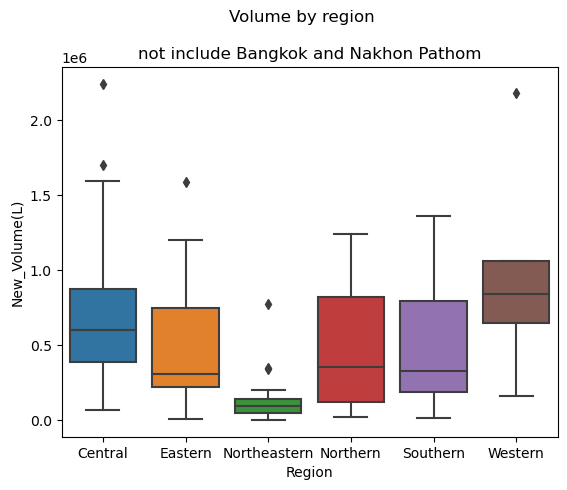

In [20]:
region_sales = churn_by_region.groupby(['Region', 'Province']).agg({'New_Volume(L)': 'sum'}).reset_index()

# distribution of total qty every province in each region not include bangkok
sns.boxplot(data=region_sales.drop(index=[1, 5]), x='Region', y='New_Volume(L)')
plt.suptitle('Volume by region', y=1)
plt.title('not include Bangkok and Nakhon Pathom')

In [21]:
region_sales[ region_sales['New_Volume(L)'] > 6500000 ]

,Region,Province,New_Volume(L)
1,Central,Bangkok,7394073
5,Central,Nakhon Pathom,6855471


extract monthly

In [22]:
churn_by_region.rename(columns={'quarter': 'month'}, inplace=True)
churn_by_region['month'] = churn_by_region['Invoicedate'].dt.month

volume_by_group = churn_by_region.groupby(['GroupId', 'Province', 'Material Name', 'month'])\
                                    .agg({'New_Volume(L)': 'sum'}).reset_index()
# volume_by_group['volume_diff'] = volume_by_group.groupby(['GroupId', 'Province', 'Material Name'])['New_Volume(L)']\
#                                                 .transform('diff').fillna(0)

volume_by_group.head()

,GroupId,Province,Material Name,month,New_Volume(L)
0,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 12X1L/CAR,7,2328
1,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 12X1L/CAR,11,5532
2,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,5,12544
3,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,9,8120
4,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,11,5040


In [23]:
# Shift the columns to get next month and volume
volume_by_group['next_month'] = volume_by_group.groupby(['GroupId', 'Province', 'Material Name'])['month'].shift(-1)
volume_by_group['next_volume'] = volume_by_group.groupby(['GroupId', 'Province', 'Material Name'])['New_Volume(L)'].shift(-1)

monthly_sales = volume_by_group.dropna().rename(columns={'New_Volume(L)': 'cur_volume'}).reset_index(drop=True)
monthly_sales['volume_diff'] = monthly_sales['next_volume'] - monthly_sales['cur_volume']

print(monthly_sales.shape)
monthly_sales.head()

(3811, 8)


,GroupId,Province,Material Name,month,cur_volume,next_month,next_volume,volume_diff
0,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 12X1L/CAR,7,2328,11.0,5532.0,3204.0
1,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,5,12544,9.0,8120.0,-4424.0
2,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,9,8120,11.0,5040.0,-3080.0
3,ERW_A1DS2023040002,Bangkok,M SUP AIO Protection 5W-30 4x4+1L/CAR,5,7160,10.0,4580.0,-2580.0
4,ERW_A1DS2023040005,Udon Thani,M DEL LEGEND CH-4 15W-40 H.D. CTN4X7L:TH,11,16436,12.0,5908.0,-10528.0


Churn classification

In [24]:
monthly_sales['Churn'] = ' '
monthly_sales.loc[monthly_sales.volume_diff == 0, 'Churn'] = 'No'
monthly_sales.loc[monthly_sales.volume_diff < 0, 'Churn'] = 'Yes'

In [25]:
avg_volume_province = volume_by_group.groupby(['Province', 'month'])\
                                        .agg({'New_Volume(L)': 'mean'})\
                                        .rename(columns={'New_Volume(L)': 'province_mean_vol'})
                                        
churn_prep = pd.merge(monthly_sales, avg_volume_province, on=['Province', 'month'], how='left')

for ind in churn_prep.index:
    diff = churn_prep.loc[ind, 'volume_diff']
    if diff > 0:
        if (churn_prep.loc[ind, 'next_month'] - churn_prep.loc[ind, 'month']) >= 3\
            and churn_prep.loc[ind, 'cur_volume'] < churn_prep.loc[ind, 'province_mean_vol']:
                churn_prep.loc[ind, 'Churn'] = 'Yes'
        else:
            churn_prep.loc[ind, 'Churn'] = 'No'
            
churn_prep.head()

,GroupId,Province,Material Name,month,cur_volume,next_month,next_volume,volume_diff,Churn,province_mean_vol
0,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 12X1L/CAR,7,2328,11.0,5532.0,3204.0,Yes,5704.601852
1,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,5,12544,9.0,8120.0,-4424.0,Yes,6171.292308
2,ERW_A1DS2023040002,Bangkok,M SUP AIO PROTECTION TBS 5W-30 4X7L/CAR,9,8120,11.0,5040.0,-3080.0,Yes,5955.371681
3,ERW_A1DS2023040002,Bangkok,M SUP AIO Protection 5W-30 4x4+1L/CAR,5,7160,10.0,4580.0,-2580.0,Yes,6171.292308
4,ERW_A1DS2023040005,Udon Thani,M DEL LEGEND CH-4 15W-40 H.D. CTN4X7L:TH,11,16436,12.0,5908.0,-10528.0,Yes,8415.000000


In [26]:
churn_prep.drop(columns='province_mean_vol').to_csv('Machine_learning/churn.csv', index=False)